In [1]:
%pdb off
%matplotlib inline

Automatic pdb calling has been turned OFF


## Module loading

In [2]:
from astropy.time import Time, TimeDelta
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import Angle
import numpy as np
import logging
import matplotlib.pyplot as plt

In [3]:
log = logging.getLogger("nenupy")
log.setLevel(logging.INFO)

from nenupy.schedule import (
    Schedule,
    ReservedBlock,
    ObsBlock,
    ESTarget,
    SSTarget,
    Constraints,
    ElevationCnst,
    MeridianTransitCnst,
    AzimuthCnst,
    LocalTimeCnst,
    TimeRangeCnst
)
from nenupy.instru import MiniArray, NenuFAR, Polarization
from nenupy.instru.interferometer import ObservingMode
from nenupy.astro.pointing import Pointing
from nenupy.astro.target import FixedTarget, SolarSystemTarget
from nenupy.astro.sky import HpxSky, Sky
from nenupy.astro.skymodel import HpxGSM

## astropy

### Time

In [4]:
t = Time("2021-11-17 16:00:00")
t.isot

'2021-11-17T16:00:00.000'

In [5]:
t.jd

2459536.1666666665

In [6]:
t.mjd

59535.666666666664

### TimeDelta

In [7]:
dt = Time("2021-11-17 16:00:00") - Time("2021-11-17 14:00:00")
type(dt)

astropy.time.core.TimeDelta

In [8]:
dt.sec

7199.999999999994

In [9]:
( Time("2021-11-17 16:00:00") + TimeDelta(3600, format="sec") ).isot

'2021-11-17T17:00:00.000'

### Quantity

In [10]:
u.Quantity(180, unit="deg")
angle = 10*u.deg    # Other method to instantiates a Quantity
angle.to(u.arcmin)

<Quantity 600. arcmin>

In [11]:
( 10*u.cm * 1*u.m ).to(u.m**2)

<Quantity 0.1 m2>

In [12]:
frequencies = np.linspace(15, 85, 20) * u.MHz

In [13]:
speed_of_light = 3e5*u.km/u.s
frequency = 30*u.MHz
wavelength = speed_of_light/frequency
wavelength

<Quantity 10000. km / (MHz s)>

In [14]:
wavelength.to(u.m)

<Quantity 10. m>

In [15]:
frequency = 30*u.MHz
wavelength = frequency.to(
    u.m, equivalencies=u.spectral()
)
wavelength

<Quantity 9.99308193 m>

### SkyCoord

In [16]:
vir_a = SkyCoord.from_name("Virgo A")    # Get a source coordinates from Simbad
vir_a.ra.deg, vir_a.dec.deg              # Print RA/Dec in degrees

(187.70593076, 12.39112329)

In [17]:
source = SkyCoord(ra=300*u.deg, dec=45*u.deg)                 # Arbitrary sky position
source_galactic_coords = source.transform_to("galactic")      # Transformation to Galactic frame
source_galactic_coords.l.deg, source_galactic_coords.b.deg    # Galactic longitude/latitude

(79.92173411857246, 7.8719395931795155)

In [18]:
ource = SkyCoord(ra=300*u.deg, dec=45*u.deg)    # Compute the angular separation between two SkyCoords
separation = source.separation(vir_a)
type(separation)

astropy.coordinates.angles.Angle

In [19]:
separation.deg

96.3306375837498

## Observation scheduling

[Documenation Scheduling](https://nenupy.readthedocs.io/en/latest/obs/obs_scheduling.html)

### Empty schedule

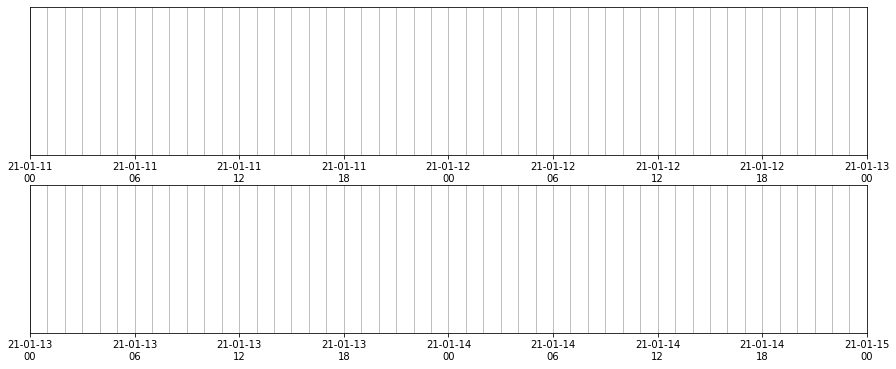

In [20]:
schedule = Schedule(
    time_min=Time('2021-01-11 00:00:00'),    # Schedule start time
    time_max=Time('2021-01-15 00:00:00'),    # Schedule stop time
    dt=TimeDelta(3600, format='sec')         # Schedule granularity / time slot duration
)
schedule.plot(days_per_line=2)

### Reserved time slots

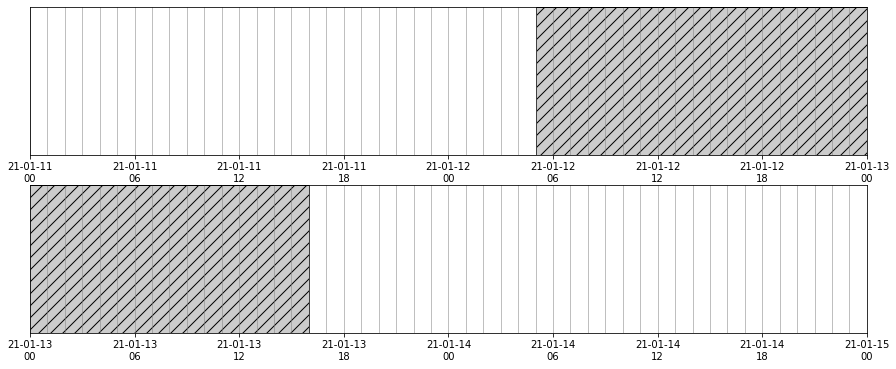

In [21]:
schedule = Schedule(
    time_min=Time('2021-01-11 00:00:00'),
    time_max=Time('2021-01-15 00:00:00'),
    dt=TimeDelta(3600, format='sec')
)
maintenance = ReservedBlock(
    time_min=Time('2021-01-12 05:00:00'),
    time_max=Time('2021-01-13 16:00:00')
)
schedule.insert(maintenance)
schedule.plot(days_per_line=2)

### Observation blocks

In [22]:
vira = ObsBlock(
    name='Virgo A',
    program='es00',
    target=ESTarget.fromName('Vir A'),        # Or SSTarget (Solar System Target)
    duration=TimeDelta(3600, format='sec')    # Observation duration → will be set at schedule.dt
)

#### Combining observation blocks

In [23]:
cyga = ObsBlock(
    name='Cyg A',
    program='es00',
    target=ESTarget.fromName('Cyg A'),
    duration=TimeDelta(3600, format='sec'),
)
my_observations = vira*2 + cyga*3    # Multiply and/or add ObsBlocks together

In [24]:
type(my_observations), my_observations.size

(nenupy.schedule.obsblocks.Block, 5)

### Constaints

In [25]:
obs_constraints = Constraints(
    ElevationCnst(elevationMin=10*u.deg),
    MeridianTransitCnst()
)

vira = ObsBlock(
    name='Virgo A',
    program='es00',
    target=ESTarget.fromName('Vir A'),
    duration=TimeDelta(3600, format='sec'),
    constraints=obs_constraints
)

2021-11-16 10:38:17 | INFO: Evaluating observation block constraints over the schedule...
2021-11-16 10:38:17 | INFO: 1 observation blocks have been successfully evaluated.
2021-11-16 10:38:17 | INFO: Fitting 1 observation blocks...
2021-11-16 10:38:17 | INFO: 1/1 observation blocks scheduled (0 impossible to fit).


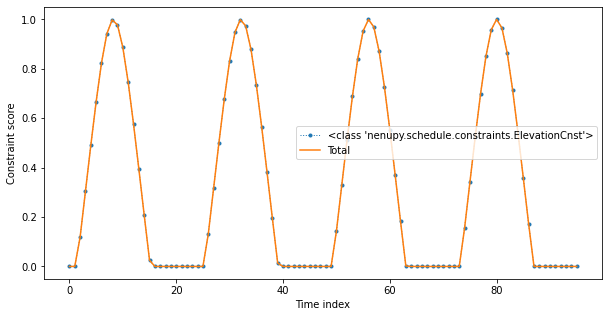

In [26]:
schedule = Schedule(
    time_min=Time('2021-11-15 00:00:00'),
    time_max=Time('2021-11-19 00:00:00')
)

vira = ObsBlock(
    name='Virgo A',
    program='es00',
    target=ESTarget.fromName('Vir A'),
    duration=TimeDelta(3600*4, format='sec')
)    # By default ElevationCnst(elevationMin=0*u.deg) is selected as standard constraint

schedule.insert(vira)

schedule.book( optimize=False )

schedule.observation_blocks[0].constraints.plot()

2021-11-16 10:38:18 | INFO: Evaluating observation block constraints over the schedule...
2021-11-16 10:38:18 | INFO: 1 observation blocks have been successfully evaluated.
2021-11-16 10:38:18 | INFO: Fitting 1 observation blocks...
2021-11-16 10:38:18 | INFO: 1/1 observation blocks scheduled (0 impossible to fit).


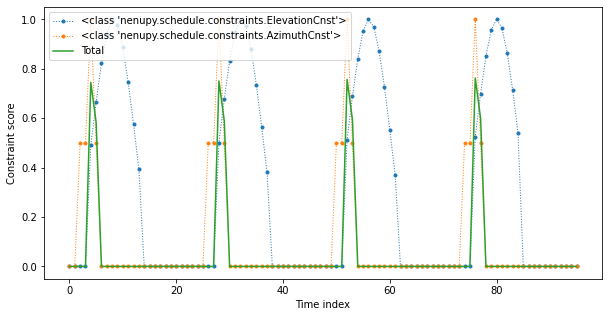

In [27]:
schedule = Schedule(
    time_min=Time('2021-11-15 00:00:00'),
    time_max=Time('2021-11-19 00:00:00')
)

vira = ObsBlock(
    name='Virgo A',
    program='es00',
    target=ESTarget.fromName('Vir A'),
    duration=TimeDelta(3600*4, format='sec'),
    constraints=Constraints( ElevationCnst(20*u.deg), AzimuthCnst(100*u.deg) ) 
)

schedule.insert(vira)

schedule.book( optimize=False )

schedule.observation_blocks[0].constraints.plot()

### Booking

#### Deterministic algorithm 

2021-11-16 10:38:18 | INFO: Evaluating observation block constraints over the schedule...
2021-11-16 10:38:18 | INFO: 1 observation blocks have been successfully evaluated.
2021-11-16 10:38:18 | INFO: Fitting 1 observation blocks...
2021-11-16 10:38:18 | INFO: 1/1 observation blocks scheduled (0 impossible to fit).


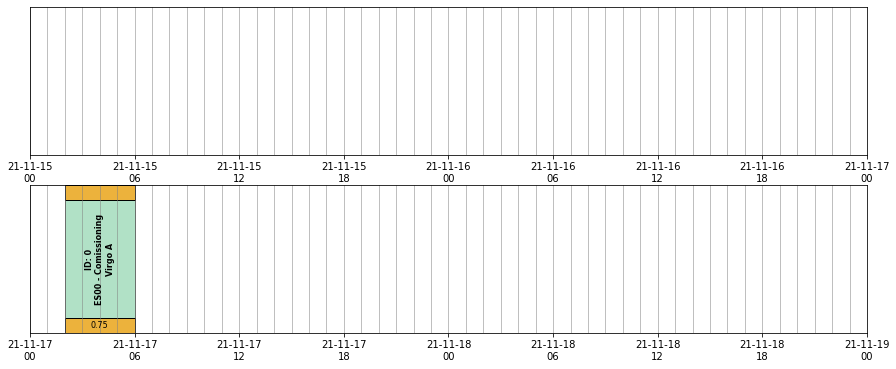

In [28]:
schedule.book( optimize=False )    # Use deterministic algorithm to solve
schedule.plot(days_per_line=2)

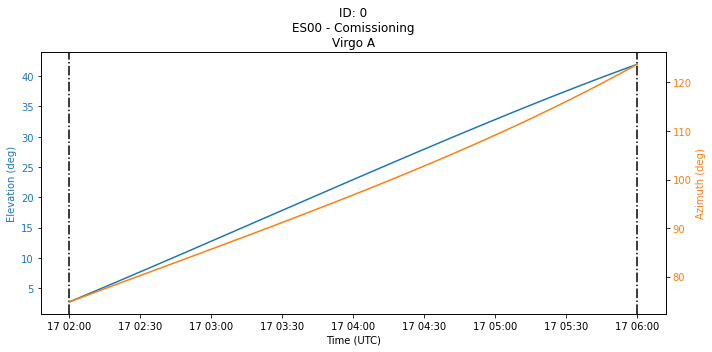

In [29]:
schedule.observation_blocks[0].plot()

#### Limits of the deterministic algorithm

2021-11-16 10:38:19 | INFO: Evaluating observation block constraints over the schedule...
2021-11-16 10:38:20 | INFO: 1 observation blocks have been successfully evaluated.
2021-11-16 10:38:20 | INFO: Fitting 1 observation blocks...
2021-11-16 10:38:20 | INFO: 1/1 observation blocks scheduled (0 impossible to fit).


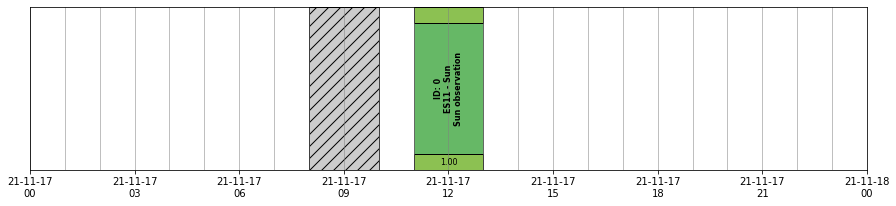

In [30]:
schedule = Schedule(
    time_min=Time('2021-11-17 00:00:00'),
    time_max=Time('2021-11-18 00:00:00')
)

schedule.insert(
    ReservedBlock(
        time_min=Time('2021-11-17 08:00:00'),
        time_max=Time('2021-11-17 10:00:00')
    )
)

sun = ObsBlock(
    name='Sun observation',
    program='es11',
    target=SSTarget.fromName('Sun'),
    duration=TimeDelta(2*3600, format='sec'),
    constraints=Constraints( ElevationCnst(elevationMin=12) )
)

schedule.insert(sun)  # ONE Sun observation

schedule.book(optimize=False)

schedule.plot()

2021-11-16 10:38:21 | INFO: Evaluating observation block constraints over the schedule...
2021-11-16 10:38:21 | INFO: 2 observation blocks have been successfully evaluated.
2021-11-16 10:38:21 | INFO: Fitting 2 observation blocks...
2021-11-16 10:38:21 | INFO: 2/2 observation blocks scheduled (0 impossible to fit).


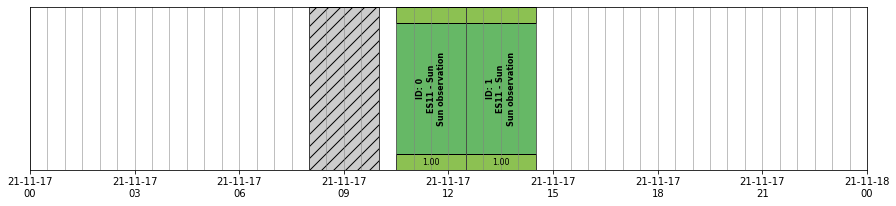

In [31]:
schedule = Schedule(
    time_min=Time('2021-11-17 00:00:00'),
    time_max=Time('2021-11-18 00:00:00'),
    dt=TimeDelta(1800, format="sec")
)

schedule.insert(
    ReservedBlock(
        time_min=Time('2021-11-17 08:00:00'),
        time_max=Time('2021-11-17 10:00:00')
    )
)

sun = ObsBlock(
    name='Sun observation',
    program='es11',
    target=SSTarget.fromName('Sun'),
    duration=TimeDelta(2*3600, format='sec'),
    constraints=Constraints( ElevationCnst(elevationMin=12) )
)

schedule.insert(sun * 2)  # TWO Sun observation

schedule.book(optimize=False)

schedule.plot()

2021-11-16 10:38:21 | INFO: Evaluating observation block constraints over the schedule...
2021-11-16 10:38:21 | INFO: 3 observation blocks have been successfully evaluated.
2021-11-16 10:38:21 | INFO: Fitting 3 observation blocks...
2021-11-16 10:38:21 | WARNING: <ObsBlock> #2 'Sun observation' cannot be scheduled.
2021-11-16 10:38:21 | INFO: 2/3 observation blocks scheduled (0 impossible to fit).


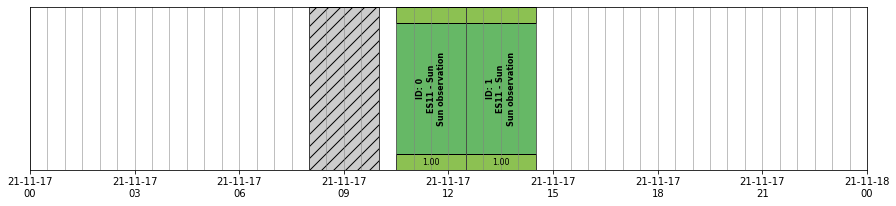

In [32]:
schedule = Schedule(
    time_min=Time('2021-11-17 00:00:00'),
    time_max=Time('2021-11-18 00:00:00'),
    dt=TimeDelta(1800, format="sec")
)

schedule.insert(
    ReservedBlock(
        time_min=Time('2021-11-17 08:00:00'),
        time_max=Time('2021-11-17 10:00:00')
    )
)

sun = ObsBlock(
    name='Sun observation',
    program='es11',
    target=SSTarget.fromName('Sun'),
    duration=TimeDelta(2*3600, format='sec'),
    constraints=Constraints( ElevationCnst(elevationMin=12) )
)

schedule.insert(sun * 3)  # THREE Sun observation

schedule.book(optimize=False)

schedule.plot()

#### Genetic algorithm

2021-11-16 10:38:21 | INFO: Evaluating observation block constraints over the schedule...
2021-11-16 10:38:21 | INFO: 3 observation blocks have been successfully evaluated.
2021-11-16 10:38:21 | INFO: Fitting 3 observation blocks...
2021-11-16 10:38:21 | INFO: Genetic algorithm launched.
2021-11-16 10:38:22 | INFO: Maximal score has stagnated for 100 generations, interrupting the evolution at generation 182.
2021-11-16 10:38:22 | INFO: 3/3 observation blocks scheduled (0 impossible to fit).


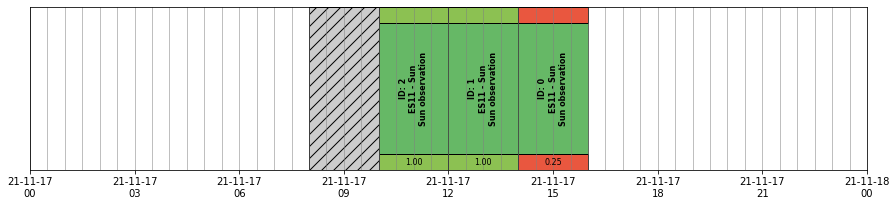

In [33]:
schedule = Schedule(
    time_min=Time('2021-11-17 00:00:00'),
    time_max=Time('2021-11-18 00:00:00'),
    dt=TimeDelta(1800, format="sec")
)

schedule.insert(
    ReservedBlock(
        time_min=Time('2021-11-17 08:00:00'),
        time_max=Time('2021-11-17 10:00:00')
    )
)

sun = ObsBlock(
    name='Sun observation',
    program='es11',
    target=SSTarget.fromName('Sun'),
    duration=TimeDelta(2*3600, format='sec'),
    constraints=Constraints( ElevationCnst(elevationMin=12) )
)

schedule.insert(sun * 3)  # THREE Sun observation

ga = schedule.book( optimize=True ) # Use genetic algorithm

schedule.plot()

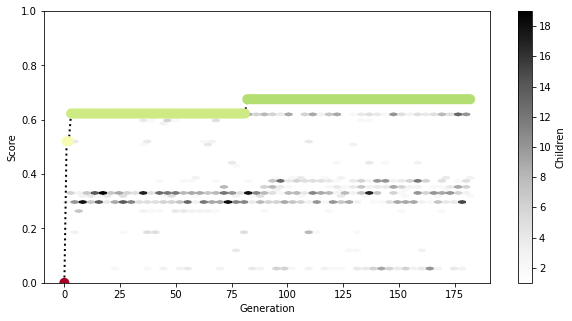

In [34]:
ga.plot()

#### A more complex observing request

2021-11-16 10:38:22 | INFO: Evaluating observation block constraints over the schedule...
2021-11-16 10:38:23 | INFO: 8 observation blocks have been successfully evaluated.
2021-11-16 10:38:23 | INFO: Fitting 8 observation blocks...
2021-11-16 10:38:23 | INFO: Genetic algorithm launched.
2021-11-16 10:38:31 | INFO: Genetic algorithm reached maximal generation 1000. Best score: 0.7818379156056662.
2021-11-16 10:38:31 | WARNING: <ObsBlock> #7 'PSR J0953+0755' cannot be scheduled.
2021-11-16 10:38:31 | INFO: 7/8 observation blocks scheduled (0 impossible to fit).


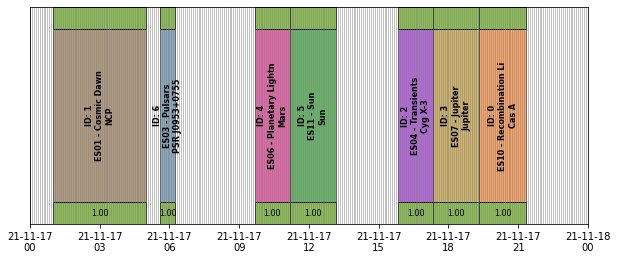

In [35]:
schedule = Schedule(
    time_min=Time('2021-11-17 00:00:00'),
    time_max=Time('2021-11-18 00:00:00'),
    dt=TimeDelta(10*30, format='sec')
)

# Observation blocks definition
cas_a = ObsBlock(
    name="Cas A",
    program="ES10",
    target=ESTarget.fromName("Cas A"),
    duration=TimeDelta(2*3600, format='sec'),
    constraints=Constraints(LocalTimeCnst(
        hMin=Angle(18, unit="h"),
        hMax=Angle(9, unit="h"))
    )
)
ncp = ObsBlock(
    name="NCP",
    program="ES01",
    target=ESTarget.fromName("North Celestial Pole"),
    duration=TimeDelta(4*3600, format='sec'),
    constraints=Constraints(LocalTimeCnst(
        hMin=Angle(20, unit="h"),
        hMax=Angle(6, unit="h"))
    )
)
pulsar = ObsBlock(
    name="PSR J0953+0755",
    program='es03',
    target=ESTarget.fromName("PSR J0953+0755"),
    duration=TimeDelta(40*60, format='sec'),
    constraints = Constraints(
        ElevationCnst(0),
        TimeRangeCnst(
            time_min=Time('2021-11-17 05:00:00'),
            time_max=Time('2021-11-17 09:00:00')),
        MeridianTransitCnst())
)
pulsars = pulsar * 2
mars = ObsBlock(
    name="Mars",
    program="ES06",
    target=SSTarget.fromName("Mars"),
    duration=TimeDelta(1.5*3600, format='sec'),
    constraints=Constraints( MeridianTransitCnst() )
)
jupiter = ObsBlock(
    name="Jupiter",
    program="ES07",
    target=SSTarget.fromName("Jupiter"),
    duration=TimeDelta(2*3600, format='sec'),
    constraints=Constraints( MeridianTransitCnst() )
)
sun = ObsBlock(
    name="Sun",
    program="ES11",
    target=SSTarget.fromName("Sun"),
    duration=TimeDelta(2*3600, format='sec'),
    constraints=Constraints( ElevationCnst(10), MeridianTransitCnst() )
)
cyg_x3 = ObsBlock(
    name="Cyg X-3",
    program="ES04",
    target=ESTarget.fromName("Cyg X-3"),
    duration=TimeDelta(1.5*3600, format='sec'),
    constraints=Constraints( MeridianTransitCnst() )
)

# Combine all observation blocks
my_observations = cas_a + ncp  + cyg_x3 + jupiter + mars + sun + pulsars

# Insert them in the schedule
schedule.insert(my_observations)

# Genetic algorithm booking
ga = schedule.book(
    optimize=True, # Computes the booking using the GA algorithm
    population_size=100, # Number of individuals per generation
    generation_max=1000, # Stops the evolution after 1000 generations
    max_stagnating_generations=-1, # Stops the evolution if the best score has not increased over N gen.
    score_threshold=1., # Stops the evolution if the best score is above this value
    random_individuals=10, # Adds individuals with random genomes at each generation
    crossover='TPCO', # Defines the cross-over method
    selection='TNS' # Defines the parent selection method
)

# Plot the solution
schedule.plot(
    figsize=(10, 4),
)

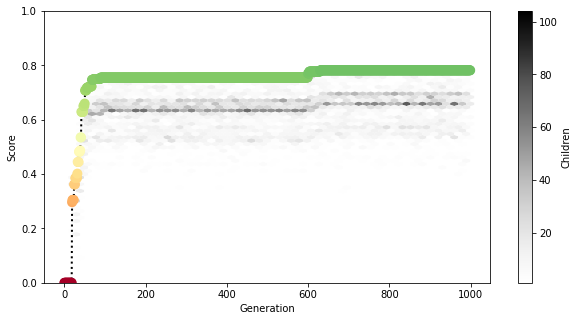

In [36]:
ga.plot()

In [37]:
schedule.export()

obsid,name,program,start,stop,score
int64,str14,str4,object,object,float64
1,NCP,es01,2021-11-17T01:00:00.000,2021-11-17T05:00:00.000,1.0
6,PSR J0953+0755,es03,2021-11-17T05:35:00.000,2021-11-17T06:15:00.000,1.0
4,Mars,es06,2021-11-17T09:40:00.000,2021-11-17T11:10:00.000,1.0
5,Sun,es11,2021-11-17T11:10:00.000,2021-11-17T13:10:00.000,1.0
2,Cyg X-3,es04,2021-11-17T15:50:00.000,2021-11-17T17:20:00.000,1.0
3,Jupiter,es07,2021-11-17T17:20:00.000,2021-11-17T19:20:00.000,1.0
0,Cas A,es10,2021-11-17T19:20:00.000,2021-11-17T21:20:00.000,1.0


## Array configuration

[Documentation array configuration](https://nenupy.readthedocs.io/en/latest/instru/array_configuration.html)

### Mini-Array

In [38]:
ma = MiniArray(index=10)
ma.rotation

<Quantity 290. deg>

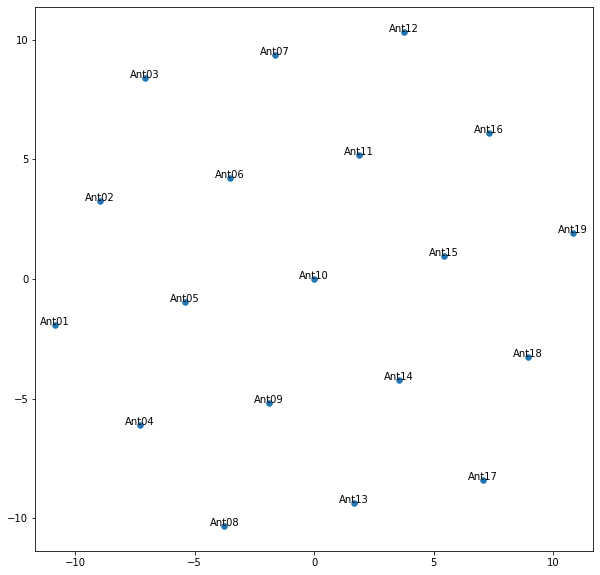

2021-11-16 10:38:33 | INFO: Interferometer.plot completed in 0.344 sec.


In [39]:
ma.plot()

#### NenuFAR

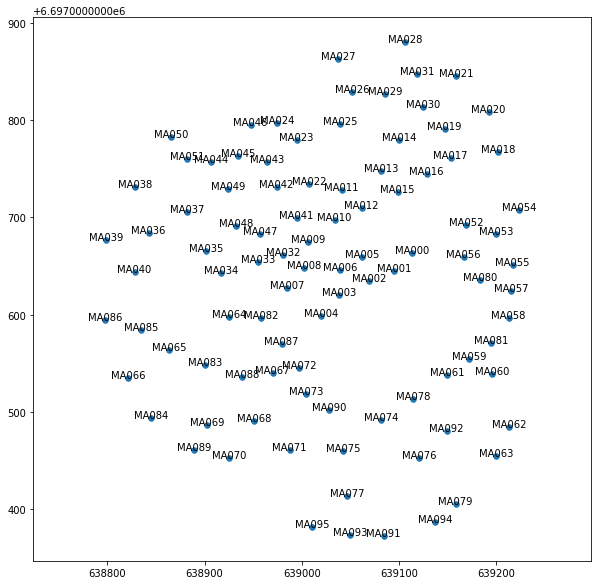

2021-11-16 10:38:34 | INFO: Interferometer.plot completed in 0.614 sec.


In [40]:
nenufar_core = NenuFAR()
nenufar_core.plot()

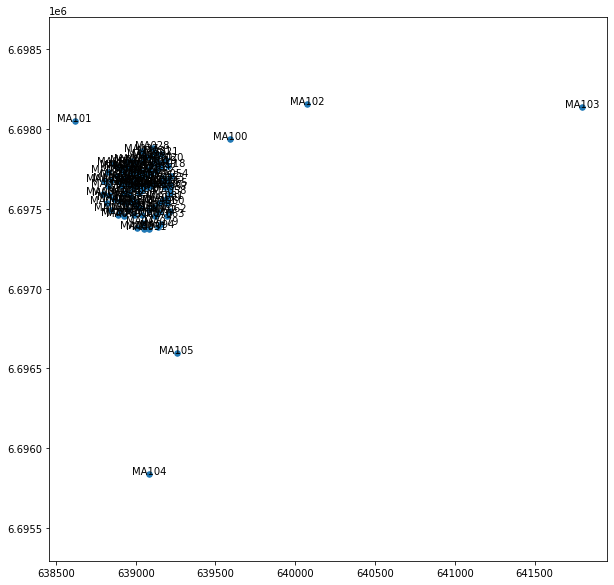

2021-11-16 10:38:34 | INFO: Interferometer.plot completed in 0.717 sec.


In [41]:
nenufar_remote = NenuFAR(include_remote_mas=True)
nenufar_remote.plot()

#### Sub-set of NenuFAR

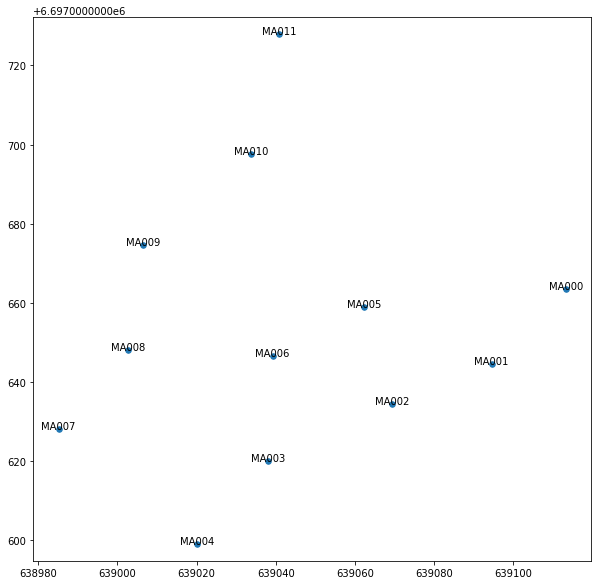

2021-11-16 10:38:35 | INFO: Interferometer.plot completed in 0.189 sec.


In [42]:
nenufar_12mas = NenuFAR()[:12]
nenufar_12mas.plot()

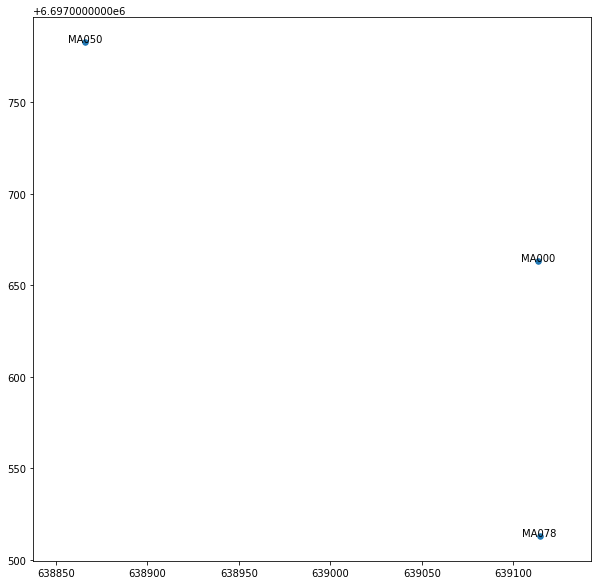

2021-11-16 10:38:35 | INFO: Interferometer.plot completed in 0.154 sec.


In [43]:
nenufar_3ma = NenuFAR()["MA000", "MA050", "MA078"]
nenufar_3ma.plot()

## Telescope properties

[Documentation telescope properties](https://nenupy.readthedocs.io/en/latest/instru/instrument_properties.html)

### Angular resolution

In [44]:
ma = MiniArray()
ma.angular_resolution(frequency=[15, 27, 48, 85]*u.MHz)

2021-11-16 10:38:35 | INFO: Interferometer.angular_resolution completed in 0.001 sec.


<Quantity [52.0510381 , 28.91724339, 16.26594941,  9.18547731] deg>

In [45]:
nenufar_subset = NenuFAR()[10:30]
nenufar_core.angular_resolution(frequency=[15, 27, 48, 85]*u.MHz)

2021-11-16 10:38:35 | INFO: Interferometer.angular_resolution completed in 0.284 sec.


<Quantity [2.11180059, 1.17322255, 0.65993768, 0.37267069] deg>

In [46]:
nenufar_core = NenuFAR()
nenufar_core.angular_resolution(frequency=[15, 27, 48, 85]*u.MHz)

2021-11-16 10:38:36 | INFO: Interferometer.angular_resolution completed in 0.239 sec.


<Quantity [2.11180059, 1.17322255, 0.65993768, 0.37267069] deg>

In [47]:
nenufar_remote = NenuFAR(include_remote_mas=True)
resolutions = nenufar_remote.angular_resolution(frequency=[15, 27, 48, 85]*u.MHz)
resolutions.to(u.arcmin)

2021-11-16 10:38:36 | INFO: Interferometer.angular_resolution completed in 0.234 sec.


<Quantity [19.31245814, 10.72914341,  6.03514317,  3.40808085] arcmin>

### Effective area

In [48]:
antenna = MiniArray()["Ant10"]
antenna.effective_area(frequency=[15, 27, 48, 85]*u.MHz)

2021-11-16 10:38:36 | INFO: MiniArray.effective_area completed in 0.020 sec.


<Quantity [133.1019862 ,  41.11744051,  13.00953857,   4.15313928] m2>

In [49]:
ma = MiniArray()
ma.effective_area(frequency=[15, 27, 48, 85]*u.MHz)

2021-11-16 10:38:37 | INFO: MiniArray.effective_area completed in 0.222 sec.


<Quantity [863.77424667, 568.49379992, 247.12257859,  78.99406024] m2>

2021-11-16 10:38:37 | INFO: MiniArray.effective_area completed in 0.349 sec.


Text(0, 0.5, 'Effective area (m2)')

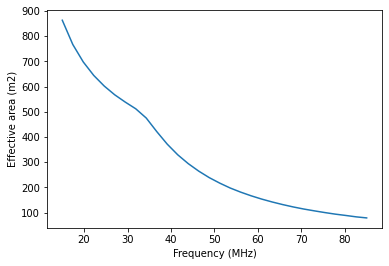

In [50]:
frequencies = np.linspace(15, 85, 30) * u.MHz
eff_area = ma.effective_area(frequency=frequencies)
plt.plot(frequencies, eff_area)
plt.xlabel("Frequency (MHz)")
plt.ylabel("Effective area (m2)")

In [51]:
nenufar_core = NenuFAR()
nenufar_core.effective_area(frequency=[15, 27, 48, 85]*u.MHz)

2021-11-16 10:38:37 | INFO: MiniArray.effective_area completed in 0.144 sec.
2021-11-16 10:38:37 | INFO: NenuFAR.effective_area completed in 0.147 sec.


<Quantity [82922.3276801 , 54575.4047923 , 23723.76754484,  7583.42978324] m2>

### Sensitivity

In [52]:
ma = MiniArray()                       # Define an array, can also be NenuFAR()...
ma.sensitivity(
    frequency=50*u.MHz,
    mode=ObservingMode.BEAMFORMING,    # beamforming / imaging
    dt=3600*u.s,                       # Exposure
    df=25*u.MHz,                       # Bandwidth
    elevation=70*u.deg,                # Mean elevation during the observation
    efficiency=1.,                     # Effective area efficiency (<= 1)
    decoherence=1.,                    # Imperfect phasing (>=1)
    lna_filter=0                       # Filter (0='no filter', 3='25 MHz high-pass filter')
)

2021-11-16 10:38:37 | INFO: MiniArray.effective_area completed in 0.090 sec.
2021-11-16 10:38:37 | INFO: Interferometer.system_temperature completed in 0.001 sec.
2021-11-16 10:38:37 | INFO: Interferometer.sefd completed in 0.096 sec.
2021-11-16 10:38:37 | INFO: Interferometer.sensitivity completed in 0.099 sec.


<Quantity 0.19055667 Jy>

2021-11-16 10:38:38 | INFO: MiniArray.effective_area completed in 0.488 sec.
2021-11-16 10:38:38 | INFO: NenuFAR.effective_area completed in 0.492 sec.
2021-11-16 10:38:38 | INFO: Interferometer.system_temperature completed in 0.001 sec.
2021-11-16 10:38:38 | INFO: Interferometer.sefd completed in 0.498 sec.
2021-11-16 10:38:38 | INFO: Interferometer.sensitivity completed in 0.501 sec.
2021-11-16 10:38:39 | INFO: MiniArray.effective_area completed in 0.508 sec.
2021-11-16 10:38:39 | INFO: NenuFAR.effective_area completed in 0.511 sec.
2021-11-16 10:38:39 | INFO: MiniArray.effective_area completed in 0.458 sec.
2021-11-16 10:38:39 | INFO: NenuFAR.effective_area completed in 0.462 sec.
2021-11-16 10:38:39 | INFO: Interferometer.system_temperature completed in 0.466 sec.
2021-11-16 10:38:39 | INFO: Interferometer.sefd completed in 0.982 sec.
2021-11-16 10:38:39 | INFO: Interferometer.sensitivity completed in 0.985 sec.


Text(0, 0.5, '$\\sigma$ (JY)')

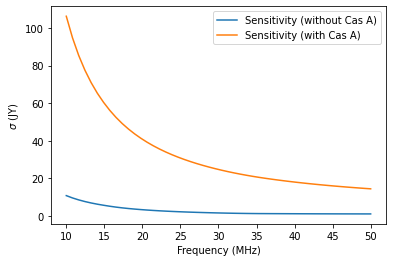

In [53]:
def casa_spectrum(frequency):
    """ Cas A spectrum """
    a0 = 3.3584
    a1 = -0.7518
    a2 = -0.0347
    a3 = -0.0705
    log_nu=np.log10(frequency.to(u.GHz).value)
    return 0.7 * np.power(10, (a0 + a1*log_nu + a2*log_nu**2 + a3*log_nu**3) )*u.Jy

frequencies = np.linspace(10, 50, 50)*u.MHz

nenufar = NenuFAR()[:56]

rms_without_cas_a = nenufar.sensitivity(
    frequency=frequencies,
    mode=ObservingMode.BEAMFORMING,
    dt=1.953*u.h,
    df=190.7*u.Hz,
    elevation=60*u.deg,
    efficiency=1,
    decoherence=1.
)

rms_with_cas_a = nenufar.sensitivity(
    frequency=frequencies,
    mode=ObservingMode.BEAMFORMING,
    dt=1.953*u.h,
    df=190.7*u.Hz,
    elevation=60*u.deg,
    efficiency=1,
    decoherence=1.,
    source_spectrum={"Cas A": casa_spectrum}
)

plt.plot(frequencies, rms_without_cas_a, label="Sensitivity (without Cas A)")
plt.plot(frequencies, rms_with_cas_a, label="Sensitivity (with Cas A)")
plt.legend()
plt.xlabel("Frequency (MHz)")
plt.ylabel(r"$\sigma$ (JY)")

## Simulation

[Documentation beam simulation](https://nenupy.readthedocs.io/en/latest/simu/beam_simulation.html)

In [54]:
simulation_dt = TimeDelta(7200, format="sec")
simulation_times = Time("2021-01-01 12:00:00") + np.arange(3)*simulation_dt

In [55]:
whole_sky = HpxSky(                              
    resolution=0.5*u.deg,                      # HEALPix resolution (defines the coordinates array)
    frequency=np.array([25, 50, 75])*u.MHz,    # Frequency array (3 elements)
    polarization=Polarization.NW,              # Single polarization (from nenupy.instru import Polarization)
    time=simulation_times                      # Time array (12 elements)
)

In [56]:
zenith = Pointing.zenith_tracking(
    time=simulation_times,
    duration=simulation_dt
)

### Antenna radiation pattern

2021-11-16 10:38:40 | INFO: Computing <class 'MiniArray'> beam (1 antennas, 3 time and 3 frequency slots).
2021-11-16 10:38:40 | INFO: MiniArray.beamsquint_correction completed in 0.002 sec.
2021-11-16 10:38:40 | INFO: MiniArray.analog_pointing completed in 0.051 sec.
2021-11-16 10:38:40 | INFO: Interferometer.array_factor completed in 0.301 sec.
2021-11-16 10:38:41 | INFO: Interferometer.beam completed in 0.858 sec.
2021-11-16 10:38:41 | INFO: MiniArray.beam completed in 0.913 sec.
[########################################] | 100% Completed |  0.1s


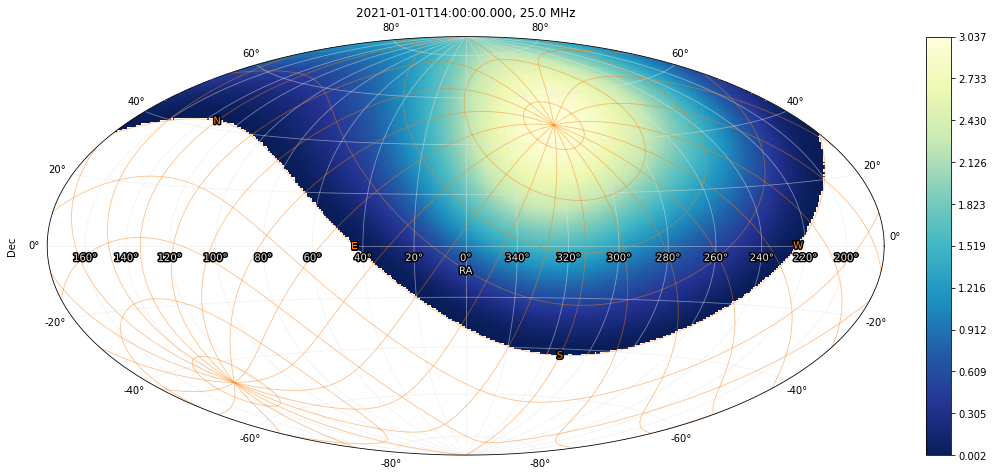

In [57]:
antenna = MiniArray()["Ant10"]
antenna_response = antenna.beam(
    sky=whole_sky,
    pointing=zenith    # Pointing doesn't matter here
)
antenna_response[1, 0, 0].plot(altaz_overlay=True)

### Mini-Array response

2021-11-16 10:38:43 | INFO: Computing <class 'MiniArray'> beam (19 antennas, 3 time and 3 frequency slots).
2021-11-16 10:38:43 | INFO: MiniArray.beamsquint_correction completed in 0.001 sec.
2021-11-16 10:38:43 | INFO: MiniArray.analog_pointing completed in 0.047 sec.
2021-11-16 10:38:43 | INFO: Interferometer.array_factor completed in 0.305 sec.
2021-11-16 10:38:43 | INFO: Interferometer.beam completed in 0.346 sec.
2021-11-16 10:38:43 | INFO: MiniArray.beam completed in 0.397 sec.
[########################################] | 100% Completed |  0.5s


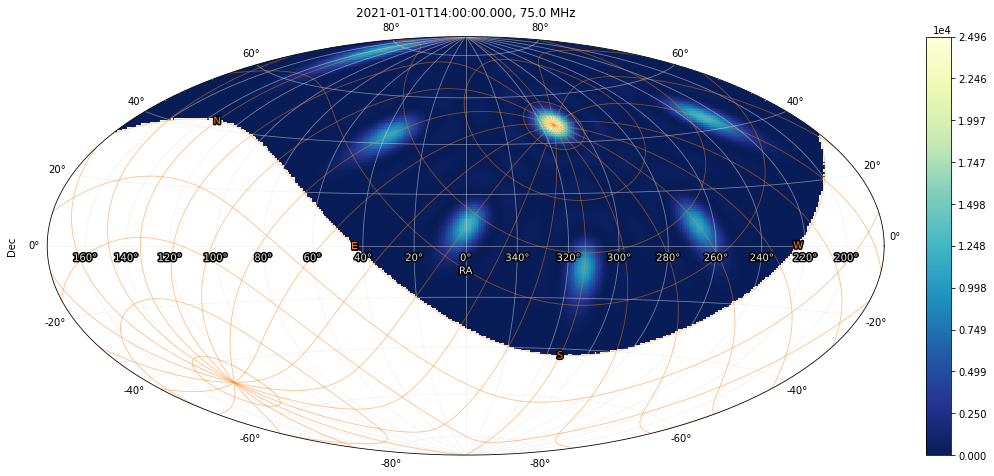

In [58]:
ma = MiniArray()
beam = ma.beam(
    sky=whole_sky,
    pointing=zenith
)
beam[1, 2, 0].plot(altaz_overlay=True)

### NenuFAR beam

#### Analog = numerical pointing

2021-11-16 10:38:45 | INFO: Computing <class 'NenuFAR'> beam (2 Mini-Arrays, 3 time and 3 frequency slots).
2021-11-16 10:38:45 | INFO: Analog pointing is set according to the numerical pointing.
2021-11-16 10:38:46 | INFO: Interferometer.array_factor completed in 0.348 sec.
2021-11-16 10:38:46 | INFO: Computing <class 'MiniArray'> beam (19 antennas, 3 time and 3 frequency slots).
2021-11-16 10:38:46 | INFO: MiniArray.beamsquint_correction completed in 0.002 sec.
2021-11-16 10:38:46 | INFO: MiniArray.analog_pointing completed in 0.056 sec.
2021-11-16 10:38:46 | INFO: Interferometer.array_factor completed in 0.328 sec.
2021-11-16 10:38:46 | INFO: Interferometer.beam completed in 0.370 sec.
2021-11-16 10:38:46 | INFO: MiniArray.beam completed in 0.430 sec.
2021-11-16 10:38:46 | INFO: Computing <class 'MiniArray'> beam (19 antennas, 3 time and 3 frequency slots).
2021-11-16 10:38:46 | INFO: MiniArray.beamsquint_correction completed in 0.001 sec.
2021-11-16 10:38:46 | INFO: MiniArray.analo

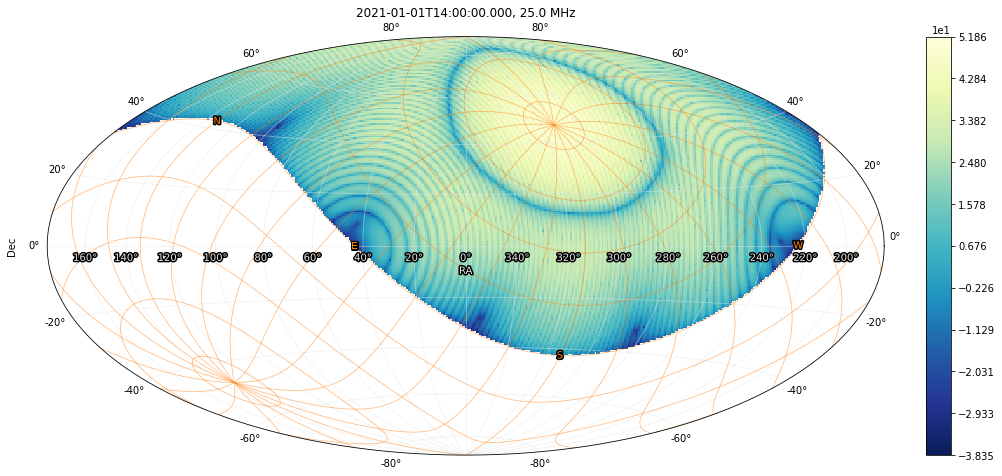

In [59]:
nenufar = NenuFAR()["MA040", "MA055"]    # East-West axis Mini-Arrays
beam = nenufar.beam(
    sky=whole_sky,
    pointing=zenith
)
beam[1, 0, 0].plot(altaz_overlay=True, decibel=True)

#### Different analog pointing

2021-11-16 10:38:49 | INFO: Computing <class 'NenuFAR'> beam (2 Mini-Arrays, 3 time and 3 frequency slots).
2021-11-16 10:38:49 | INFO: Interferometer.array_factor completed in 0.313 sec.
2021-11-16 10:38:49 | INFO: Computing <class 'MiniArray'> beam (19 antennas, 3 time and 3 frequency slots).
2021-11-16 10:38:49 | INFO: MiniArray.beamsquint_correction completed in 0.002 sec.
2021-11-16 10:38:49 | INFO: MiniArray.analog_pointing completed in 0.051 sec.
2021-11-16 10:38:50 | INFO: Interferometer.array_factor completed in 0.317 sec.
2021-11-16 10:38:50 | INFO: Interferometer.beam completed in 0.357 sec.
2021-11-16 10:38:50 | INFO: MiniArray.beam completed in 0.413 sec.
2021-11-16 10:38:50 | INFO: Computing <class 'MiniArray'> beam (19 antennas, 3 time and 3 frequency slots).
2021-11-16 10:38:50 | INFO: MiniArray.beamsquint_correction completed in 0.002 sec.
2021-11-16 10:38:50 | INFO: MiniArray.analog_pointing completed in 0.049 sec.
2021-11-16 10:38:50 | INFO: Interferometer.array_fact

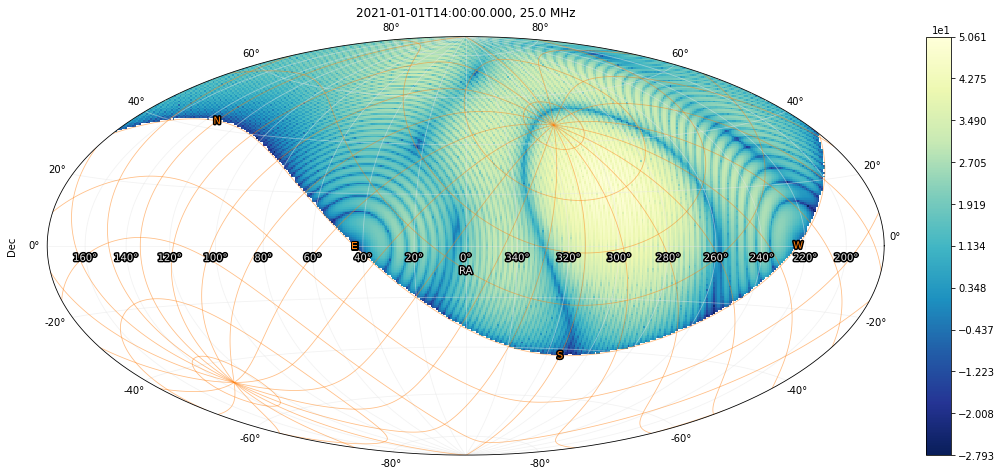

In [60]:
nenufar = NenuFAR()["MA040", "MA055"]
other_pointing = Pointing.target_tracking(
    target=FixedTarget(
        coordinates=SkyCoord(300, 20, unit="deg")
    ),
    time=simulation_times,
    duration=simulation_dt
)
beam = nenufar.beam(
    sky=whole_sky,
    pointing=zenith,
    analog_pointing=other_pointing
)
beam[1, 0, 0].plot(altaz_overlay=True, decibel=True)

#### NenuFAR core

In [61]:
nenufar = NenuFAR()    # 96 Mini-Arrays
beam = nenufar.beam(
    sky=whole_sky,
    pointing=zenith
)

2021-11-16 10:38:53 | INFO: Computing <class 'NenuFAR'> beam (96 Mini-Arrays, 3 time and 3 frequency slots).
2021-11-16 10:38:53 | INFO: Analog pointing is set according to the numerical pointing.
2021-11-16 10:38:53 | INFO: Interferometer.array_factor completed in 0.298 sec.
2021-11-16 10:38:53 | INFO: Computing <class 'MiniArray'> beam (19 antennas, 3 time and 3 frequency slots).
2021-11-16 10:38:53 | INFO: MiniArray.beamsquint_correction completed in 0.002 sec.
2021-11-16 10:38:53 | INFO: MiniArray.analog_pointing completed in 0.055 sec.
2021-11-16 10:38:53 | INFO: Interferometer.array_factor completed in 0.281 sec.
2021-11-16 10:38:53 | INFO: Interferometer.beam completed in 0.332 sec.
2021-11-16 10:38:53 | INFO: MiniArray.beam completed in 0.390 sec.
2021-11-16 10:38:53 | INFO: Computing <class 'MiniArray'> beam (19 antennas, 3 time and 3 frequency slots).
2021-11-16 10:38:53 | INFO: MiniArray.beamsquint_correction completed in 0.002 sec.
2021-11-16 10:38:53 | INFO: MiniArray.anal

[########################################] | 100% Completed |  4.2s


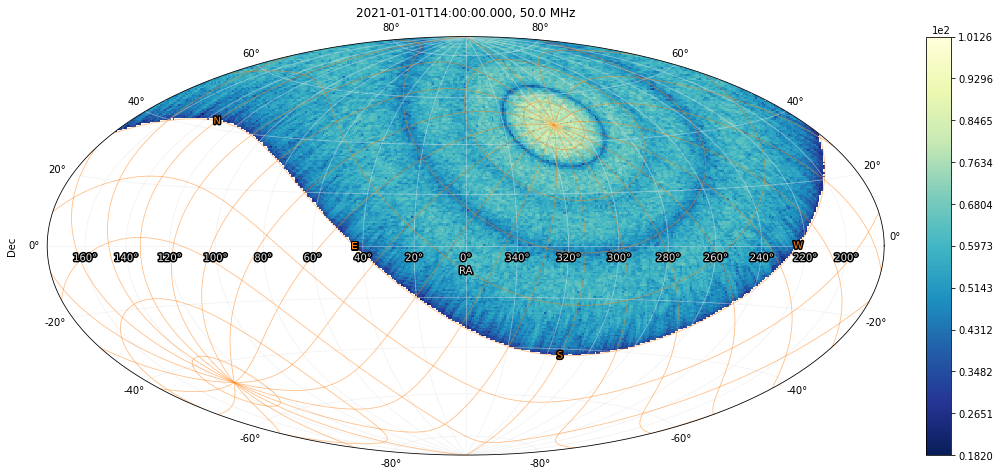

In [62]:
beam[1, 1, 0].plot(
    altaz_overlay=True,
    decibel=True
)

## Exercise

* [Documentation target ephemerides](https://nenupy.readthedocs.io/en/latest/astro/target.html)
* [Documentation pointing](https://nenupy.readthedocs.io/en/latest/astro/pointing.html)

In [63]:
vira = FixedTarget.from_name("Vir A")

vira_transit = vira.next_meridian_transit(
    time=Time("2021-11-17 16:00:00")
)

vira_transit

<Time object: scale='utc' format='iso' value=2021-11-18 08:32:42.199>

In [64]:
dt = TimeDelta(2*60, format="sec")

times = vira_transit - TimeDelta(1800, format="sec") + np.arange(31)*dt

times.isot

array(['2021-11-18T08:02:42.199', '2021-11-18T08:04:42.199',
       '2021-11-18T08:06:42.199', '2021-11-18T08:08:42.199',
       '2021-11-18T08:10:42.199', '2021-11-18T08:12:42.199',
       '2021-11-18T08:14:42.199', '2021-11-18T08:16:42.199',
       '2021-11-18T08:18:42.199', '2021-11-18T08:20:42.199',
       '2021-11-18T08:22:42.199', '2021-11-18T08:24:42.199',
       '2021-11-18T08:26:42.199', '2021-11-18T08:28:42.199',
       '2021-11-18T08:30:42.199', '2021-11-18T08:32:42.199',
       '2021-11-18T08:34:42.199', '2021-11-18T08:36:42.199',
       '2021-11-18T08:38:42.199', '2021-11-18T08:40:42.199',
       '2021-11-18T08:42:42.199', '2021-11-18T08:44:42.199',
       '2021-11-18T08:46:42.199', '2021-11-18T08:48:42.199',
       '2021-11-18T08:50:42.199', '2021-11-18T08:52:42.199',
       '2021-11-18T08:54:42.199', '2021-11-18T08:56:42.199',
       '2021-11-18T08:58:42.199', '2021-11-18T09:00:42.199',
       '2021-11-18T09:02:42.199'], dtype='<U23')

In [65]:
analog_pointing = Pointing.target_tracking(
    target=vira,    # FixedTarget previously define
    time=times,     # Time range (31 elements)
    duration=dt,    # 2min for each of the 31 sky positions
)

In [66]:
vira_transit_pointing = Pointing.target_transit(
    target=vira,                               # FixedTarget previously defined
    t_min=Time("2021-11-17 16:00:00"),         # Start time while searching for the next transit
    duration=TimeDelta(7200, format="sec"),    # Frozen pointing for 2 hours, centered on transit time
    azimuth=180*u.deg                          # az=180° → meridian transit
)

In [67]:
whole_sky = HpxSky(
    resolution=0.5*u.deg,
    frequency=50*u.MHz,
    polarization=Polarization.NW,
    time=times
)

print(whole_sky)

<class 'nenupy.astro.sky.HpxSky'> instance
value: (31, 1, 1, 196608)
	* time: (31,)
	* frequency: (1,)
	* polarization: (1,)
	* coordinates: (196608,)



In [68]:
nenufar = NenuFAR()
beam = nenufar.beam(
    sky=whole_sky,
    pointing=vira_transit_pointing,
    analog_pointing=analog_pointing
)    # ~30 seconds on my computer

print(beam)

2021-11-16 10:39:02 | INFO: Computing <class 'NenuFAR'> beam (96 Mini-Arrays, 31 time and 1 frequency slots).
2021-11-16 10:39:05 | INFO: Interferometer.array_factor completed in 3.305 sec.
2021-11-16 10:39:05 | INFO: Computing <class 'MiniArray'> beam (19 antennas, 31 time and 1 frequency slots).
2021-11-16 10:39:05 | INFO: MiniArray.beamsquint_correction completed in 0.001 sec.
2021-11-16 10:39:05 | INFO: MiniArray.analog_pointing completed in 0.340 sec.
2021-11-16 10:39:09 | INFO: Interferometer.array_factor completed in 3.196 sec.
2021-11-16 10:39:12 | INFO: Interferometer.beam completed in 6.978 sec.
2021-11-16 10:39:12 | INFO: MiniArray.beam completed in 7.323 sec.
2021-11-16 10:39:12 | INFO: Computing <class 'MiniArray'> beam (19 antennas, 31 time and 1 frequency slots).
2021-11-16 10:39:12 | INFO: MiniArray.beamsquint_correction completed in 0.002 sec.
2021-11-16 10:39:13 | INFO: MiniArray.analog_pointing completed in 0.285 sec.
2021-11-16 10:39:16 | INFO: Interferometer.array_

In [69]:
skymodel = HpxGSM.shaped_like(beam)

[########################################] | 100% Completed |  0.1s


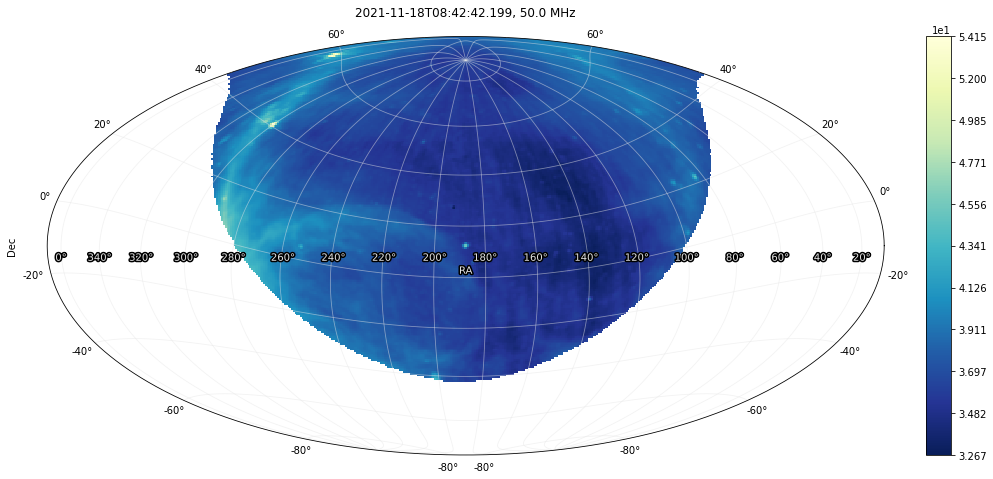

In [70]:
skymodel[20, 0, 0].plot(
    decibel=True,
    center=vira.coordinates
)

Text(0.5, 1.0, 'Vir A transit simulation (50.0 MHz)')

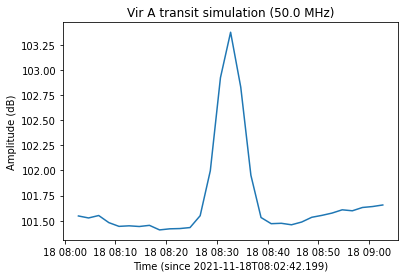

In [71]:
sky_through_beam = beam * skymodel
profile = np.nanmean(sky_through_beam.value, axis=(1, 2, 3))

plt.plot(times.datetime, 10*np.log10(profile))
plt.ylabel("Amplitude (dB)")
plt.xlabel(f"Time (since {times[0].isot})")
plt.title(f"Vir A transit simulation ({beam.frequency[0]})")